In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import ternary

In [4]:
import scipy.stats

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [6]:
import sklearn.preprocessing
import sklearn.model_selection

In [7]:
import uproot
uproot.default_library = "np"

In [8]:
import os.path

In [9]:
import logging
logging.basicConfig(level=logging.INFO)

In [10]:
np.set_printoptions(precision=4, suppress=True)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data

In [12]:
raw_names = [
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    "data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    "data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
    
    "DLA/KPsi2See_2018_MD_folded.root:DecayTree;1",
    "DLA/KPsi2S_mumu_2018MD_folded.root:DecayTree;1",

    "DLA/sim09h_Dplus_PhiPi_2018_MD_folded.root:DecayTree;1",
    "DLA/sim09h_Dplus_PhiPi_mumu_2018_MD_folded.root:DecayTree;1",
]

In [13]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

### Truthing

In [14]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_GeV > %g" % v1, "q2_GeV < %g" % v2)

In [15]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}

In [100]:
features = [
    "e_minus_TRUEPT",
    "e_plus_TRUEPT",
    "log_max_pl",
    "alpha",
    "q2",
]

In [101]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [102]:
selectors = [
    Je_selector,
    Jmu_selector,
    Kee_selector,
    Kmumu_selector,
    psi2Se_selector,
    psi2Smu_selector,
    Dphipi_ee_selector,
    Dphipi_mumu_selector,
]
selectors

['((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 6)&(q2_GeV < 12.96))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 8.68)&(q2_GeV < 10.09))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 9.82)&(q2_GeV < 16.4))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 12.5)&(q2_GeV < 14.2))',
 '((abs(e_minus_TRUEID)==11

In [103]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>

In [104]:
df_index = [
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺J/ψ(→µµ)",
    r"B⁺→K⁺ee",
    r"B⁺→K⁺µµ",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"B⁺→K⁺ψ(2S)(→µµ)",
    r"D⁺→π⁺φ(→ee)",
    r"D⁺→π⁺φ(→µµ)",
]
df = pd.DataFrame(index=df_index)

In [105]:
df["Total"] = [f["e_minus_TRUEID"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b[features[0]].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total        N   N/Total
B⁺→K⁺J/ψ(→ee)    2084124   731925  0.351191
B⁺→K⁺J/ψ(→µµ)    3206889  1460434  0.455405
B⁺→K⁺ee           413741    36689  0.088676
B⁺→K⁺µµ           665455    72527  0.108989
B⁺→K⁺ψ(2S)(→ee)   869415   247181  0.284307
B⁺→K⁺ψ(2S)(→µµ)  2313029  1039105  0.449240
D⁺→π⁺φ(→ee)       499520   149292  0.298871
D⁺→π⁺φ(→µµ)       678441   312775  0.461020

$$\begin{aligned}
R_K&=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to \mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
R_{\psi(2S)}&=\frac{\mathcal{B}(B\to K\psi(2S)(\to\mu\mu))}{\mathcal{B}(B \to K\psi(2S)(\to ee))} \Big/ \frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
, \\
r_{J/\psi}&=\frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
.
\end{aligned}$$

In [106]:
def r_K(a): return a[3]/a[2]
def r_Jpsi(a): return a[1]/a[0]
def r_psi2S(a): return a[5]/a[4]
def R_K(a): return r_K(a)/r_Jpsi(a)
def R_psi2S(a): return r_psi2S(a)/r_Jpsi(a)

def double_ratio(a): return R_K(a)
def double_ratio_psi2S(a): return R_psi2S(a)

### Graphs

In [107]:
for idx in [0, 2, 4, 6]:
    plt.hist(truthed[idx]['alpha'], label="e- %s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

In [108]:
for idx in [0, 2, 4, 6]:
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(7, 14, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

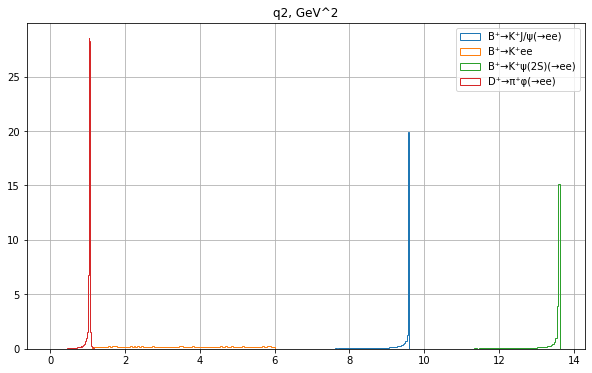

In [110]:
for idx in [0, 2, 4, 6]:
    data = truthed[idx]
    plt.hist(data['q2']*1e-6, label="%s"%df_index[idx],
             density=True, bins=100, histtype='step')
plt.title(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

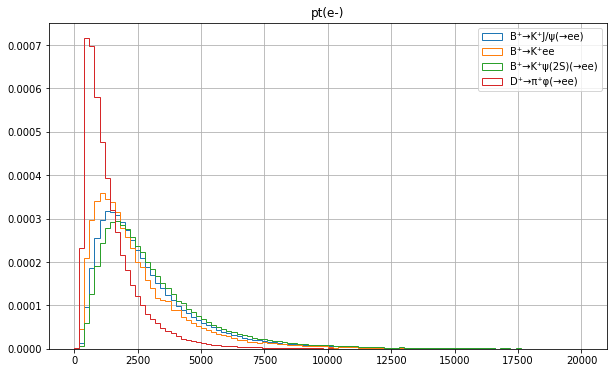

In [112]:
for idx in [0, 2, 4, 6]:
    data = truthed[idx]
    plt.hist(data['e_minus_TRUEPT'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0,20000,101), histtype='step')
plt.title(r'pt(e-)')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [113]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [114]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [115]:
X, Y, mapping = make_dataset(["alpha", "log_max_pl"], [0,2,4,6])
X.shape, Y.shape, mapping

((1165087, 2), (1165087,), {0: 0, 1: 2, 2: 4, 3: 6})

In [116]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)

In [117]:
y_train.mean(), y_test.mean()

(0.840218848764708, 0.8402097692023792)

In [118]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)

StandardScaler()

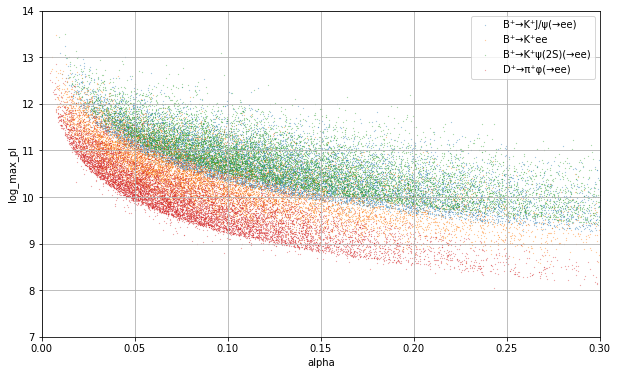

In [119]:
for label in [0,1,2,3]:
    idx = y_train==label
    x = x_train[idx][:10000]
    plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[mapping[label]])
#plt.gca().set_aspect('equal')
plt.xlim(0,0.3)
plt.ylim(7,14)
plt.xlabel("alpha")
plt.ylabel("log_max_pl")
plt.plot()
plt.legend()
plt.grid()
plt.show()

In [120]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [121]:
def get_random_samples(data, size=1000):
    index = torch.randint(len(data), size=(size,), device=device)
    return data[index]

In [122]:
# dataset is a dict of datasets
class EqualSizeLoader(object):
    def __init__(self, dataset, shape, batch_size=1, batch_number=1, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.batch_number = batch_number
        self.device = device
        self.labels = sorted(dataset.keys())
        self.shape = shape
    def __len__(self):
        return self.batch_num
    def __iter__(self):
        for i in range(0, self.batch_number):
            batch = torch.zeros(self.batch_size, len(self.labels), *self.shape, device=device)
            for i, label in enumerate(self.labels):
                index = torch.randint(len(self.dataset[label]), size=(self.batch_size,), device=device)
                batch[:,i] = self.dataset[label][index][0]
            yield batch

In [123]:
split_dataset = {label: torch.utils.data.TensorDataset(from_numpy(scaler.transform(x_train[y_train==label]))) for label in [0,1,2,3]}
split_loader = EqualSizeLoader(split_dataset, [2], batch_size=1024*8, batch_number=20, device=device)

In [124]:
dataset = torch.utils.data.TensorDataset(
    from_numpy(scaler.transform(x_train)),
    from_numpy(y_train, dtype=torch.long)
)
#loader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=True)
loader = Loader(dataset, batch_size=10000, shuffle=True, device=device)
len(dataset), len(loader)

(1048578, 105)

In [125]:
counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
counts

array([658732,  33020, 222463, 134363])

In [126]:
weights = y_train.shape[0]/counts/counts.shape[0]
weights

array([0.398 , 7.939 , 1.1784, 1.951 ])

### NN

In [127]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [128]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        total_count = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            count = x.shape[0]
            total_loss += loss
            total_count += count
            if not accumulate:
                loss /= count
                opt.zero_grad()
                loss.backward()
                opt.step()
        total_loss /= total_count
        if accumulate:
            opt.zero_grad()
            total_loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, total_loss)
    model.eval()

In [129]:
m = model().to(device)

In [130]:
%%time
train(m, loader, epochs=50, weight=weights, accumulate=False)
train(m, loader, epochs=50, weight=weights, accumulate=True)

INFO:root:Epoch 0, 1.352334
INFO:root:Epoch 1, 0.988349
INFO:root:Epoch 2, 0.866917
INFO:root:Epoch 3, 0.827077
INFO:root:Epoch 4, 0.815975
INFO:root:Epoch 5, 0.808371
INFO:root:Epoch 6, 0.802703
INFO:root:Epoch 7, 0.799212
INFO:root:Epoch 8, 0.795901
INFO:root:Epoch 9, 0.793634
INFO:root:Epoch 10, 0.792112
INFO:root:Epoch 11, 0.790289
INFO:root:Epoch 12, 0.789136
INFO:root:Epoch 13, 0.787647
INFO:root:Epoch 14, 0.786501
INFO:root:Epoch 15, 0.785325
INFO:root:Epoch 16, 0.784275
INFO:root:Epoch 17, 0.783477
INFO:root:Epoch 18, 0.782324
INFO:root:Epoch 19, 0.781416
INFO:root:Epoch 20, 0.780784
INFO:root:Epoch 21, 0.779960
INFO:root:Epoch 22, 0.779249
INFO:root:Epoch 23, 0.778794
INFO:root:Epoch 24, 0.778434
INFO:root:Epoch 25, 0.777908
INFO:root:Epoch 26, 0.777435
INFO:root:Epoch 27, 0.777074
INFO:root:Epoch 28, 0.776804
INFO:root:Epoch 29, 0.777075
INFO:root:Epoch 30, 0.776311
INFO:root:Epoch 31, 0.776100
INFO:root:Epoch 32, 0.776162
INFO:root:Epoch 33, 0.775708
INFO:root:Epoch 34, 0.77

CPU times: user 25.1 s, sys: 332 ms, total: 25.4 s
Wall time: 25.3 s


In [131]:
m.eval()

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [132]:
def plot_field(f, name=None, save=None):
    x_min = 0.0
    x_max = 0.3
    y_min = 7
    y_max = 14
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=1.0, vmin=0.0)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("alpha")
    plt.ylabel("log_max_pl")
    plt.grid()
    #plt.gca().set_aspect('equal')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [133]:
def plot_clf(clf, c0, c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(scaler.transform(x))))))
    plot_field(f,r'$\sigma\left(\log\frac{p(%s|x)}{p(%s|x)}\right)$'%(df_index[mapping[c1]],df_index[mapping[c0]]))

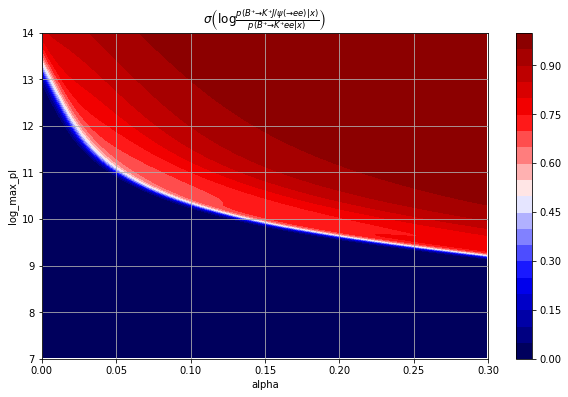

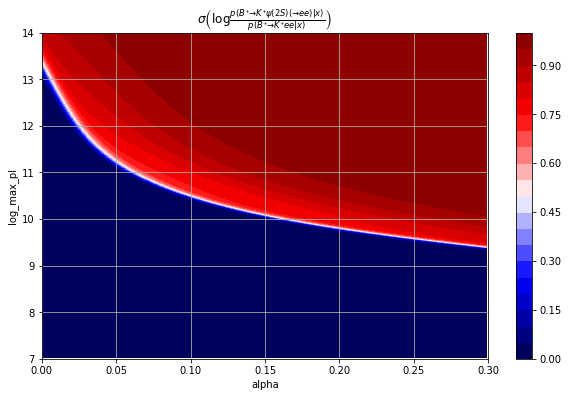

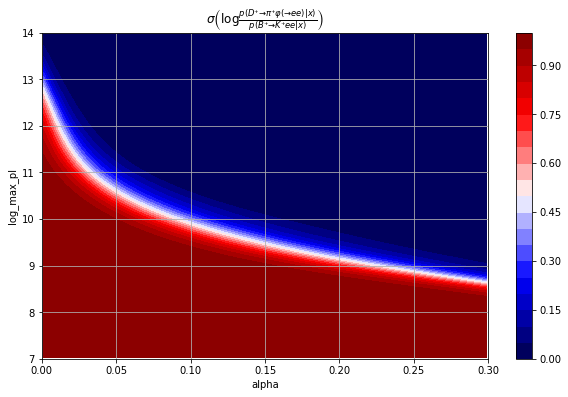

In [134]:
plot_clf(m,1,0)
plot_clf(m,1,2)
plot_clf(m,1,3)

In [193]:
def plot_clf_min_max(clf):
    fn = lambda x : x[...,[0,2,3]] - x[...,1:2]
    f_min = lambda x : to_numpy(torch.sigmoid(torch.min(fn(clf(from_numpy(scaler.transform(x)))), dim=-1)[0]))
    f_max = lambda x : to_numpy(torch.sigmoid(torch.max(fn(clf(from_numpy(scaler.transform(x)))), dim=-1)[0]))
    plot_field(f_min,r'$\min_i\sigma\left(\log\frac{p(c_i|x)}{p(c|x)}\right)$')
    plot_field(f_max,r'$\max_i\sigma\left(\log\frac{p(c_i|x)}{p(c|x)}\right)$')

In [194]:
plot_clf_min_max(m)

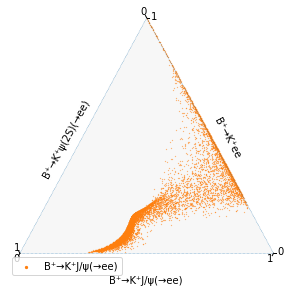

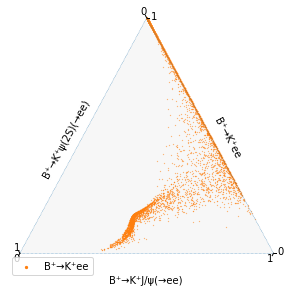

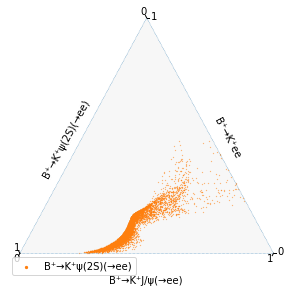

In [135]:
for label in [0,1,2]:
    fig, tax = ternary.figure(scale=1.0)
    fig.set_size_inches(5, 5)

    idx = y_train==label
    x = x_train[idx][:10000]
    v = to_numpy(torch.softmax(m(from_numpy(scaler.transform(x)))[:,0:3], dim=1))
    tax.scatter(v, marker=".", s=0.2, label="%s"%df_index[mapping[label]])
    
    tax.gridlines(multiple=20)
    tax.get_axes().axis('off')
    tax.left_axis_label(df_index[mapping[2]])
    tax.right_axis_label(df_index[mapping[1]])
    tax.bottom_axis_label(df_index[mapping[0]])
    plt.legend(markerscale=10)
    tax.ticks(axis='lbr', linewidth=1)
    plt.show()

### Weight limits estimation

$$\begin{aligned}
\inf_x\frac{p_1(x)}{p_0(x)}
\leq
\frac{\mathbb{E}_{x\sim p_1}[w(x)]}{\mathbb{E}_{x\sim p_0}[w(x)]}
\leq
\sup_x\frac{p_1(x)}{p_0(x)}
.
\end{aligned}$$

### Crafting a loss

In [136]:
def ratio_estimator(vec):
    m_minus = np.sum(np.maximum(-vec, 0))
    m_plus = np.sum(np.maximum(vec, 0))
    return 1/m_minus

In [137]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W

In [138]:
def train_pinv(model, loader, selected_class, epochs=50, alpha=0.001):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    n_outs = 4 # N
    n_classes = 4 # n
    for epoch in range(epochs):
        W = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        
        wcj = W_pinv[selected_class]
        wcj_ = (wcj<0)
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)
        W_m = np.multiply.outer(wcj, wki)
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        #print(pred.shape, W.shape, W_pinv.shape)
        #print(W_pinv, w1j, wki, W_m)
        #print(ratio_estimator(w1j))
        #loss = torch.sum(W*from_numpy(W_m_))
        loss_c = torch.sum(W*from_numpy(W_m_))
        loss_d = -torch.sum(W*(W_pinv_.T))
        loss = loss_d + alpha * loss_c
        opt.zero_grad()
        loss.backward()
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d, loss=%f est=%f" % (epoch, loss, ratio_estimator(W_pinv[selected_class])),
              W_pinv[selected_class],
              det)
        #raise NotImplementedError
    model.eval()

In [139]:
m_la = model().to(device)
m_la.load_state_dict(m.state_dict())

<All keys matched successfully>

In [140]:
%%time
# 1 for Kee
train_pinv(m_la, loader, 1, epochs=200, alpha=0.001)
train_pinv(m_la, loader, 1, epochs=500, alpha=300)

Epoch 0, loss=-4.000105 est=0.260509 [-2.6139  3.7043  1.1393 -1.2247] 0.013163338
Epoch 1, loss=-4.000103 est=0.278786 [-2.4198  3.6754  0.9364 -1.1672] 0.014693445
Epoch 2, loss=-4.000103 est=0.296245 [-2.2467  3.6432  0.7712 -1.1289] 0.016223047
Epoch 3, loss=-4.000103 est=0.313217 [-2.0844  3.6034  0.6327 -1.1083] 0.01775715
Epoch 4, loss=-4.000103 est=0.329704 [-1.9333  3.5563  0.5177 -1.0997] 0.01930183
Epoch 5, loss=-4.000103 est=0.345608 [-1.7946  3.5036  0.4234 -1.0988] 0.020856116
Epoch 6, loss=-4.000103 est=0.360847 [-1.6695  3.4483  0.3473 -1.1017] 0.022411129
Epoch 7, loss=-4.000104 est=0.375442 [-1.5582  3.3937  0.2866 -1.1053] 0.023954537
Epoch 8, loss=-4.000105 est=0.389538 [-1.4595  3.3421  0.2384 -1.1077] 0.025474552
Epoch 9, loss=-4.000105 est=0.403342 [-1.3714  3.2947  0.1999 -1.1079] 0.0269614
Epoch 10, loss=-4.000105 est=0.417075 [-1.2915  3.2523  0.1688 -1.1061] 0.02840855
Epoch 11, loss=-4.000106 est=0.430916 [-1.2178  3.2147  0.1433 -1.1028] 0.029812701
Epoch 1

Epoch 99, loss=-4.000095 est=0.914000 [-0.1963  2.4617  0.021  -0.8978] 0.063692495
Epoch 100, loss=-4.000095 est=0.915582 [-0.1953  2.4601  0.0209 -0.8969] 0.06377562
Epoch 101, loss=-4.000095 est=0.917158 [-0.1944  2.4586  0.0208 -0.8959] 0.0638573
Epoch 102, loss=-4.000095 est=0.918729 [-0.1935  2.4571  0.0207 -0.895 ] 0.06393762
Epoch 103, loss=-4.000095 est=0.920292 [-0.1926  2.4557  0.0206 -0.894 ] 0.064016625
Epoch 104, loss=-4.000095 est=0.921842 [-0.1917  2.4543  0.0205 -0.893 ] 0.06409434
Epoch 105, loss=-4.000095 est=0.923370 [-0.1909  2.4529  0.0204 -0.8921] 0.06417082
Epoch 106, loss=-4.000094 est=0.924870 [-0.1901  2.4515  0.0203 -0.8911] 0.06424591
Epoch 107, loss=-4.000095 est=0.926340 [-0.1893  2.4502  0.0202 -0.8902] 0.064319886
Epoch 108, loss=-4.000094 est=0.927778 [-0.1885  2.4488  0.0201 -0.8893] 0.064392686
Epoch 109, loss=-4.000094 est=0.929185 [-0.1877  2.4475  0.02   -0.8885] 0.06446432
Epoch 110, loss=-4.000094 est=0.930566 [-0.187   2.4462  0.02   -0.8876] 0

Epoch 198, loss=-4.000092 est=1.008293 [-0.1542  2.3814  0.0155 -0.8376] 0.06814994
Epoch 199, loss=-4.000092 est=1.008872 [-0.154   2.381   0.0155 -0.8372] 0.06817438
Epoch 0, loss=-31.421459 est=1.009448 [-0.1539  2.3806  0.0155 -0.8368] 0.06819859
Epoch 1, loss=-27.527332 est=1.136228 [-0.1445  2.5237  0.0152 -0.7356] 0.067697905
Epoch 2, loss=-24.210066 est=1.266131 [-0.1343  2.6907  0.0146 -0.6555] 0.06629184
Epoch 3, loss=-21.390432 est=1.396450 [-0.1254  2.8852  0.014  -0.5907] 0.06409625
Epoch 4, loss=-19.004877 est=1.523415 [-0.1186  3.1114  0.0136 -0.5379] 0.061248507
Epoch 5, loss=-16.995522 est=1.643992 [-0.1135  3.3719  0.0134 -0.4948] 0.05793769
Epoch 6, loss=-15.306933 est=1.756475 [-0.1096  3.6675  0.0134 -0.4597] 0.054368347
Epoch 7, loss=-13.888099 est=1.860157 [-0.1065  3.9979  0.0134 -0.4311] 0.05071843
Epoch 8, loss=-12.694039 est=1.955015 [-0.1038  4.3623  0.0134 -0.4077] 0.047124024
Epoch 9, loss=-11.686872 est=2.041374 [-0.1014  4.7593  0.0134 -0.3884] 0.0436799

Epoch 96, loss=-7.354344 est=2.628625 [-0.0729  9.152   0.0157 -0.3075] 0.023389691
Epoch 97, loss=-7.340461 est=2.631985 [-0.0728  9.1809  0.0157 -0.3071] 0.023318106
Epoch 98, loss=-7.326869 est=2.635299 [-0.0727  9.2092  0.0157 -0.3068] 0.023248624
Epoch 99, loss=-7.313590 est=2.638559 [-0.0726  9.2369  0.0157 -0.3064] 0.023181243
Epoch 100, loss=-7.300669 est=2.641758 [-0.0725  9.2639  0.0157 -0.306 ] 0.023116125
Epoch 101, loss=-7.288120 est=2.644893 [-0.0725  9.2902  0.0157 -0.3056] 0.023053357
Epoch 102, loss=-7.275959 est=2.647963 [-0.0724  9.3157  0.0157 -0.3053] 0.022992985
Epoch 103, loss=-7.264205 est=2.650962 [-0.0723  9.3403  0.0157 -0.3049] 0.022935132
Epoch 104, loss=-7.252864 est=2.653888 [-0.0723  9.364   0.0157 -0.3045] 0.022879755
Epoch 105, loss=-7.241943 est=2.656740 [-0.0723  9.3869  0.0157 -0.3041] 0.02282695
Epoch 106, loss=-7.231448 est=2.659517 [-0.0723  9.4088  0.0157 -0.3037] 0.022776723
Epoch 107, loss=-7.221381 est=2.662213 [-0.0722  9.4298  0.0157 -0.303

Epoch 194, loss=-6.592662 est=2.889592 [-0.0713 10.808   0.0143 -0.2748] 0.020082561
Epoch 195, loss=-6.585170 est=2.892950 [-0.0713 10.8267  0.0143 -0.2744] 0.020051103
Epoch 196, loss=-6.577695 est=2.896318 [-0.0712 10.8454  0.0142 -0.274 ] 0.020019678
Epoch 197, loss=-6.570224 est=2.899707 [-0.0712 10.8641  0.0142 -0.2736] 0.01998834
Epoch 198, loss=-6.562761 est=2.903111 [-0.0712 10.8828  0.0142 -0.2732] 0.019957023
Epoch 199, loss=-6.555306 est=2.906536 [-0.0712 10.9016  0.0142 -0.2728] 0.0199258
Epoch 200, loss=-6.547868 est=2.909971 [-0.0712 10.9205  0.0142 -0.2725] 0.019894604
Epoch 201, loss=-6.540441 est=2.913422 [-0.0712 10.9393  0.0142 -0.2721] 0.019863477
Epoch 202, loss=-6.533015 est=2.916896 [-0.0712 10.9582  0.0141 -0.2717] 0.0198324
Epoch 203, loss=-6.525609 est=2.920379 [-0.0712 10.9771  0.0141 -0.2713] 0.01980138
Epoch 204, loss=-6.518204 est=2.923884 [-0.0711 10.9961  0.0141 -0.2709] 0.019770412
Epoch 205, loss=-6.510818 est=2.927404 [-0.0711 11.015   0.0141 -0.2705

Epoch 292, loss=-5.969028 est=3.272027 [-0.0724 12.5269  0.0128 -0.2332] 0.017579721
Epoch 293, loss=-5.964424 est=3.276112 [-0.0724 12.5398  0.0128 -0.2328] 0.01756336
Epoch 294, loss=-5.959780 est=3.280235 [-0.0725 12.553   0.0128 -0.2324] 0.017546825
Epoch 295, loss=-5.955105 est=3.284389 [-0.0725 12.5663  0.0128 -0.232 ] 0.01753006
Epoch 296, loss=-5.950381 est=3.288584 [-0.0725 12.5799  0.0127 -0.2316] 0.017512988
Epoch 297, loss=-5.945602 est=3.292824 [-0.0725 12.5939  0.0127 -0.2312] 0.017495573
Epoch 298, loss=-5.940753 est=3.297115 [-0.0725 12.6081  0.0127 -0.2308] 0.01747772
Epoch 299, loss=-5.935826 est=3.301465 [-0.0725 12.6228  0.0127 -0.2304] 0.0174594
Epoch 300, loss=-5.930810 est=3.305881 [-0.0725 12.6379  0.0127 -0.23  ] 0.017440567
Epoch 301, loss=-5.925712 est=3.310358 [-0.0725 12.6535  0.0126 -0.2296] 0.017421193
Epoch 302, loss=-5.920517 est=3.314902 [-0.0725 12.6696  0.0126 -0.2292] 0.017401204
Epoch 303, loss=-5.915220 est=3.319526 [-0.0724 12.6862  0.0126 -0.228

Epoch 391, loss=-5.495272 est=3.753943 [-0.0702 14.2296  0.0105 -0.1962] 0.015658304
Epoch 392, loss=-5.491974 est=3.758450 [-0.0701 14.2438  0.0105 -0.1959] 0.015643679
Epoch 393, loss=-5.488701 est=3.762943 [-0.0701 14.2579  0.0105 -0.1956] 0.01562914
Epoch 394, loss=-5.485455 est=3.767419 [-0.0701 14.2719  0.0105 -0.1953] 0.015614692
Epoch 395, loss=-5.482229 est=3.771889 [-0.0701 14.286   0.0105 -0.195 ] 0.015600352
Epoch 396, loss=-5.479027 est=3.776342 [-0.0701 14.2999  0.0105 -0.1947] 0.015586073
Epoch 397, loss=-5.475853 est=3.780777 [-0.07   14.3139  0.0104 -0.1945] 0.015571886
Epoch 398, loss=-5.472695 est=3.785206 [-0.07   14.3277  0.0104 -0.1942] 0.015557784
Epoch 399, loss=-5.469567 est=3.789617 [-0.07   14.3416  0.0104 -0.1939] 0.015543774
Epoch 400, loss=-5.466458 est=3.794016 [-0.07   14.3553  0.0104 -0.1936] 0.015529827
Epoch 401, loss=-5.463371 est=3.798403 [-0.07   14.3691  0.0104 -0.1933] 0.015515965
Epoch 402, loss=-5.460308 est=3.802778 [-0.07   14.3827  0.0104 -0

Epoch 489, loss=-5.263971 est=4.124167 [-0.0695 15.3767  0.01   -0.173 ] 0.014567379
Epoch 490, loss=-5.262322 est=4.127208 [-0.0695 15.3862  0.01   -0.1728] 0.014558975
Epoch 491, loss=-5.260688 est=4.130226 [-0.0695 15.3956  0.01   -0.1726] 0.014550606
Epoch 492, loss=-5.259059 est=4.133241 [-0.0695 15.4051  0.01   -0.1724] 0.014542274
Epoch 493, loss=-5.257447 est=4.136230 [-0.0695 15.4144  0.01   -0.1723] 0.014533994
Epoch 494, loss=-5.255838 est=4.139219 [-0.0695 15.4238  0.0099 -0.1721] 0.014525746
Epoch 495, loss=-5.254247 est=4.142178 [-0.0695 15.4331  0.0099 -0.1719] 0.014517542
Epoch 496, loss=-5.252660 est=4.145136 [-0.0695 15.4424  0.0099 -0.1718] 0.014509368
Epoch 497, loss=-5.251090 est=4.148068 [-0.0695 15.4516  0.0099 -0.1716] 0.014501257
Epoch 498, loss=-5.249522 est=4.151000 [-0.0695 15.4608  0.0099 -0.1714] 0.014493162
Epoch 499, loss=-5.247969 est=4.153910 [-0.0695 15.4699  0.0099 -0.1712] 0.014485123
CPU times: user 1min 6s, sys: 162 ms, total: 1min 6s
Wall time: 1

In [141]:
@torch.no_grad()
def make_weighting(model, loader, selected_class):
    W = to_numpy(create_w(model, loader, 4, 4))
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    print(1/m_minus)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=1), linear)

In [142]:
fn = make_weighting(m_la, loader, 1)
fn_np = lambda x : to_numpy(fn(from_numpy(scaler.transform(x))))

[[0.3619 0.2846 0.1251 0.0415]
 [0.0012 0.0709 0.     0.0106]
 [0.635  0.1819 0.8749 0.0027]
 [0.0019 0.4626 0.     0.9451]]
|W| =  0.014477118
[[  3.7509 -13.6169  -0.5364  -0.0102]
 [ -0.0695  15.479    0.0099  -0.1711]
 [ -2.708    6.6876   1.5303   0.0394]
 [  0.0266  -7.5497  -0.0038   1.1419]]
5.845144511036805
tensor([0.0065, 1.0000, 0.0116, 0.0000], device='cuda:0')


### Result analysis

In [143]:
plot_field(fn_np, r'$w(x)$', save='result.pdf')

In [144]:
df = df.iloc[0:8,0:3]

In [145]:
df["1-w"] = 1
df["w"] = 1
for label, idx in mapping.items():
    d = X[Y==label]
    wd = fn_np(d)
    df.loc[df.index[idx],"w"] = np.mean(wd)
    df.loc[df.index[idx],"1-w"] = 1-np.mean(wd)
    df.loc[df.index[idx],"min w"] = np.min(wd)
    df.loc[df.index[idx],"max w"] = np.max(wd)
df

Total        N   N/Total       1-w         w         min w  \
B⁺→K⁺J/ψ(→ee)    2084124   731925  0.351191  0.989071  0.010929  4.229202e-06   
B⁺→K⁺J/ψ(→µµ)    3206889  1460434  0.455405  1.000000  1.000000           NaN   
B⁺→K⁺ee           413741    36689  0.088676  0.924944  0.075056  1.947178e-16   
B⁺→K⁺µµ           665455    72527  0.108989  1.000000  1.000000           NaN   
B⁺→K⁺ψ(2S)(→ee)   869415   247181  0.284307  0.989068  0.010932  5.904157e-03   
B⁺→K⁺ψ(2S)(→µµ)  2313029  1039105  0.449240  1.000000  1.000000           NaN   
D⁺→π⁺φ(→ee)       499520   149292  0.298871  0.989130  0.010870  3.888814e-31   
D⁺→π⁺φ(→µµ)       678441   312775  0.461020  1.000000  1.000000           NaN   

                    max w  
B⁺→K⁺J/ψ(→ee)    0.999997  
B⁺→K⁺J/ψ(→µµ)         NaN  
B⁺→K⁺ee          1.000000  
B⁺→K⁺µµ               NaN  
B⁺→K⁺ψ(2S)(→ee)  0.011567  
B⁺→K⁺ψ(2S)(→µµ)       NaN  
D⁺→π⁺φ(→ee)      0.999885  
D⁺→π⁺φ(→µµ)           NaN

In [146]:
double_ratio(df["1-w"]), double_ratio_psi2S(df["1-w"])

(1.0693305357877314, 1.0000035640185134)

In [147]:
1/double_ratio(df["1-w"]), 1/double_ratio_psi2S(df["1-w"])

(0.9351645413018543, 0.9999964359941887)

In [148]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(0.14560780165316164, 0.9996775529669302)

In [149]:
1/double_ratio(df["w"]), 1/double_ratio_psi2S(df["w"])

(6.867763874232535, 1.0003225510386953)

###

In [182]:
X_q2, Y_q2, mapping_q2 = make_dataset(["alpha", "log_max_pl", "q2", "e_minus_TRUEPT"], [0,2,4,6])

<ipython-input-183-22cb1e446e90>:10: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-183-22cb1e446e90>:10: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-183-22cb1e446e90>:10: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
<ipython-input-183-22cb1e446e90>:10: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])


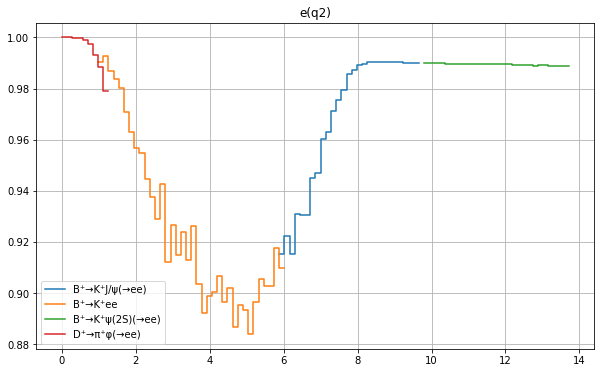

In [183]:
bins_q2 = np.linspace(0,14e6,101)
for label, idx in mapping_q2.items():
    d = X_q2[Y_q2==label]
    wd = 1-fn_np(d[:,0:2])
    q2d = d[:,2]
    h1 = np.histogram(q2d, bins=bins_q2)[0]
    hw = np.histogram(q2d, bins=bins_q2, weights=wd)[0]
    #plt.step(bins_q2[:-1]*1e-6, h1, where='post')
    #plt.step(bins_q2[:-1]*1e-6, hw, where='post')
    plt.step(bins_q2[:-1]*1e-6, hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(q2)")
plt.legend()
plt.show()

<ipython-input-184-69d817e8ec93>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-184-69d817e8ec93>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-184-69d817e8ec93>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])


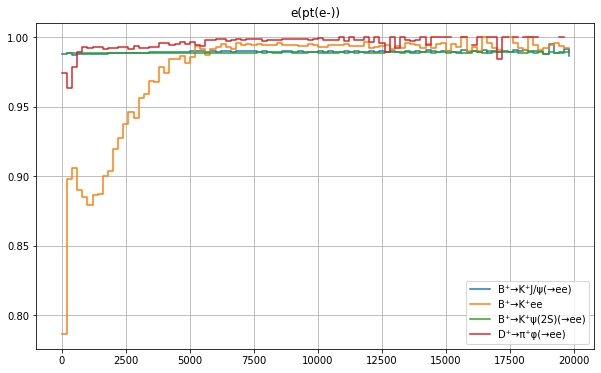

In [184]:
bins_ept = np.linspace(0,20000,101)
for label, idx in mapping_q2.items():
    d = X_q2[Y_q2==label]
    wd = 1-fn_np(d[:,0:2])
    ept = d[:,3]
    h1 = np.histogram(ept, bins=bins_ept)[0]
    hw = np.histogram(ept, bins=bins_ept, weights=wd)[0]
    plt.step(bins_ept[:-1], hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(pt(e-))")
plt.legend()
plt.show()

In [195]:
truthed_B = [f.arrays(features + ["B_plus_TRUEPT"], sel, aliases=aliases, library="np") for f, sel in zip(raw_files[:6], selectors)]

<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide


<ipython-input-196-76c0719418b3>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-196-76c0719418b3>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])
<ipython-input-196-76c0719418b3>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])


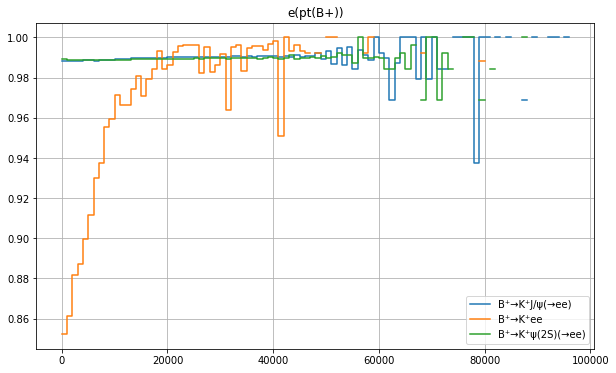

In [196]:
bins_B = np.linspace(0,100000,101)
for label, idx in enumerate([0,2,4]):
    d = np.hstack([truthed_B[idx][fn].reshape(-1, 1) for fn in ["alpha", "log_max_pl", "B_plus_TRUEPT"]])
    wd = 1-fn_np(d[:,0:2])
    Bpt = d[:,2]
    h1 = np.histogram(Bpt, bins=bins_B)[0]
    hw = np.histogram(Bpt, bins=bins_B, weights=wd)[0]
    plt.step(bins_B[:-1], hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(pt(B+))")
plt.legend()
plt.show()

In [198]:
truthed_D = [f.arrays(features + ["D_plus_TRUEPT"], sel, aliases=aliases, library="np") for f, sel in zip(raw_files[6:], selectors[6:])]

<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: divide by zero encountered in log
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide


<ipython-input-201-8423829c9ff7>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.step(bins_D[:-1], hw/h1, where='post', label=df_index[idx])


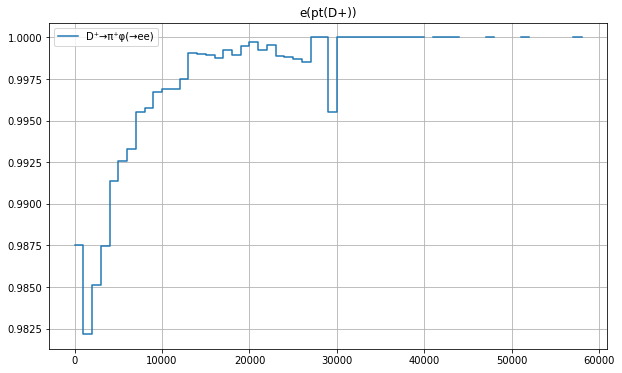

In [201]:
bins_D = np.linspace(0,100000,101)
for label, idx in enumerate([6]):
    d = np.hstack([truthed_D[idx-6][fn].reshape(-1, 1) for fn in ["alpha", "log_max_pl", "D_plus_TRUEPT"]])
    wd = 1-fn_np(d[:,0:2])
    Dpt = d[:,2]
    h1 = np.histogram(Dpt, bins=bins_D)[0]
    hw = np.histogram(Dpt, bins=bins_D, weights=wd)[0]
    plt.step(bins_D[:-1], hw/h1, where='post', label=df_index[idx])
plt.grid()
plt.title("e(pt(D+))")
plt.legend()
plt.show()